In [27]:
# Delphi PID exploration!  Here we aim to study reco PID performance

In [4]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import ROOT

uproot.default_library = "np"

Welcome to JupyROOT 6.26/06


ldd: exited with unknown exit code (139)


In [5]:
file = uproot.open("nanoaod_kk2f4146_qqpy_91.25_40262.sdst_ttree.root")
tree = file["t"]

In [6]:
tree.keys()

['Btag_probAllIP',
 'Btag_probNegIP',
 'Btag_probPosIP',
 'Btag_thrustVector',
 'Btag_thrustVector/fCoordinates',
 'Btag_thrustVector/fCoordinates/fCoordinates.fX',
 'Btag_thrustVector/fCoordinates/fCoordinates.fY',
 'Btag_thrustVector/fCoordinates/fCoordinates.fZ',
 'Btag_thrustVector_fCoordinates',
 'Btag_thrustVector_fCoordinates/fX',
 'Btag_thrustVector_fCoordinates/fY',
 'Btag_thrustVector_fCoordinates/fZ',
 'Btag_thrustVector_fCoordinates_fX',
 'Btag_thrustVector_fCoordinates_fY',
 'Btag_thrustVector_fCoordinates_fZ',
 'Dedx_error',
 'Dedx_gapWires',
 'Dedx_nrVDHits',
 'Dedx_nrWires',
 'Dedx_value',
 'Dedx_valueVD',
 'Dedx_width',
 'Elid_gammaConversion',
 'Elid_partIdx',
 'Elid_px',
 'Elid_py',
 'Elid_pz',
 'Elid_tag',
 'Event_DSTType',
 'Event_chargedMult',
 'Event_chargedMultT4',
 'Event_cmEnergy',
 'Event_date',
 'Event_evtNumber',
 'Event_fillNumber',
 'Event_hadronTagT4',
 'Event_magField',
 'Event_neutralMult',
 'Event_runNumber',
 'Event_time',
 'Event_totalChargedEnergy'

In [28]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Btag_probAllIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_probNegIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_probPosIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_thrustVector    | ROOT::Math::Displacem... | AsGroup(<TBranchElement 'Bt...
Btag_thrustVector... | ROOT::Math::Cartesian... | AsGroup(<TBranchElement 'fC...
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | ROOT::Math::Cartesian... | AsGroup(<TBranchElement 'Bt...
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | floa

In [7]:
# Some helper functions

In [8]:
def Magnitude(px, py, pz):
    return np.sqrt(px * px + py * py + pz * pz)

def DotProduct(px1, py1, pz1, px2, py2, pz2):
    return px1 * px2 + py1 * py2 + pz1 * pz2

def CosAngle(px1, py1, pz1, px2, py2, pz2):
    return DotProduct(px1, py1, pz1, px2, py2, pz2) / Magnitude(px1, py1, pz1) / Magnitude(px2, py2, pz2)

def GetAngle(px1, py1, pz1, px2, py2, pz2):
    Value = CosAngle(px1, py1, pz1, px2, py2, pz2)
    if Value < -1:
        Value = -1
    if Value > 1:
        Value = 1
    return np.arccos(Value)

In [9]:
# Now we massage things so that it is simpler to navigate.  We focus on one particle type to start with

In [30]:
GenAlias           = {}
GenAlias["px"]     = "GenPart_vector/GenPart_vector.fCoordinates.fX"
GenAlias["py"]     = "GenPart_vector/GenPart_vector.fCoordinates.fY"
GenAlias["pz"]     = "GenPart_vector/GenPart_vector.fCoordinates.fZ"
GenAlias["E"]      = "GenPart_vector/GenPart_vector.fCoordinates.fT"
GenAlias["mass"]   = "GenPart_mass"
GenAlias["id"]     = "GenPart_pdgId"
GenAlias["status"] = "GenPart_status"

AllSelection = "(status == 1)"
PionSelection = "(status == 1) & ((id == 211) | (id == -211))"
KaonSelection = "(status == 1) & ((id == 321) | (id == -321))"

Gen = tree.arrays(["px", "py", "pz", "E", "mass", "id", "status"], AllSelection, aliases = GenAlias)

RecoAlias           = {}
RecoAlias["px"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fX"
RecoAlias["py"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fY"
RecoAlias["pz"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fZ"
RecoAlias["E"]      = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fT"
RecoAlias["charge"] = "Part_charge"
RecoAlias["id"]     = "Part_pdgId"

Reco = tree.arrays(["px", "py", "pz", "E", "charge", "id"], "charge != 0", aliases = RecoAlias)

PIDAlias = {}
PIDAlias["dedx"]        = "Dedx_valueVD"
PIDAlias["ElectronTag"] = 'Haidc_electronTag'
PIDAlias["HeavyTag"]    = 'Haidc_heavyTag'
PIDAlias["KaonTag"]     = 'Haidc_kaonTag'
PIDAlias["PionTag"]     = 'Haidc_pionTag'
PIDAlias["ProtonTag"]   = 'Haidc_protonTag'
PIDAlias["Selection"]   = 'Haidc_selectionFlag'
PIDAlias["QKaonTag"]    = "Haid_kaonCombined"
PIDAlias["QProtonTag"]  = "Haid_protonCombined"

PID = tree.arrays(["dedx", "ElectronTag", "HeavyTag", "PionTag", "KaonTag", "ProtonTag", "Selection", "QKaonTag", "QProtonTag"], aliases = PIDAlias)

EventAlias = {}
EventAlias["Ecm"]   = "Event_cmEnergy"
EventAlias["Nch"]   = 'Event_chargedMult'
EventAlias["Run"]   = "Event_runNumber"
EventAlias["Event"] = "Event_evtNumber"
EventAlias["Fill"]  = "Event_fillNumber"

Event = tree.arrays(["Ecm", "Nch", "Run", "Event", "Fill"], aliases = EventAlias)

In [11]:
print('dedx branch sizes', len(tree["Dedx_valueVD"].array()[0]))
print('reco particle count', len(tree["Part_pdgId"].array()[0]))
print('charged reco particle count', len(Reco["id"][0]))
print('rich detector sizes', len(tree["Rich_thel"].array()[0]))
print('hadron ID c sizes', len(tree['Haidc_heavyTag'].array()[0]))

dedx branch sizes 14
reco particle count 29
charged reco particle count 14
rich detector sizes 14
hadron ID c sizes 14


In [12]:
PID

<Array [{dedx: [...], ...}, {...}, ..., {...}] type='3000 * {dedx: var * fl...'>

In [13]:
print("PIDs", set.union(*map(set, Gen.id)))

PIDs {-2112, 321, 2112, 130, 11, 12, 13, 14, 16, 211, 22, -2212, 2212, -211, -16, -14, -13, -12, -11, -321}


In [14]:
# Doing the simple-minded matching for now

In [15]:
GenMatch = []
GenAngle = []

for iE, entry in enumerate(Gen):
    NGen = len(Gen[iE].px)
    NReco = len(Reco[iE].px)

    # Temporarily copy things out of awkward array to make it run faster
    GenPx = np.array(Gen[iE].px)
    GenPy = np.array(Gen[iE].py)
    GenPz = np.array(Gen[iE].pz)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    MatchingIndex = np.full(NGen, -1.0)
    MatchingAngle = np.full(NGen, -1.0)
    for iG in range(NGen):
        BestIndex = -1
        BestDistance = -1
        for iR in range(NReco):
            Distance = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

            if BestIndex < 0 or BestDistance > Distance:
                BestIndex = iR
                BestDistance = Distance
            # print(Distance, BestDistance)
            # print(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

        MatchingIndex[iG] = BestIndex
        MatchingAngle[iG] = BestDistance

    GenMatch.append(MatchingIndex)
    GenAngle.append(MatchingAngle)

In [16]:
HPionAngle = ROOT.TH1D("HPionAngle", "Pions;Gen-reco matching angle;Counts", 100, 0, 2.5)
HKaonAngle = ROOT.TH1D("HKaonAngle", "Kaons;Gen-reco matching angle;Counts", 100, 0, 2.5)

for iE in range(len(GenAngle)):
    NGen = len(Gen[iE].px)
    ID = Gen[iE].id
    for iG in range(NGen):
        if ID[iG] == 211 or ID[iG] == -211:
            HPionAngle.Fill(GenAngle[iE][iG])
        if ID[iG] == 321 or ID[iG] == -321:
            HKaonAngle.Fill(GenAngle[iE][iG])

Info in <TCanvas::Print>: pdf file GenRecoMatchingAngle.pdf has been created


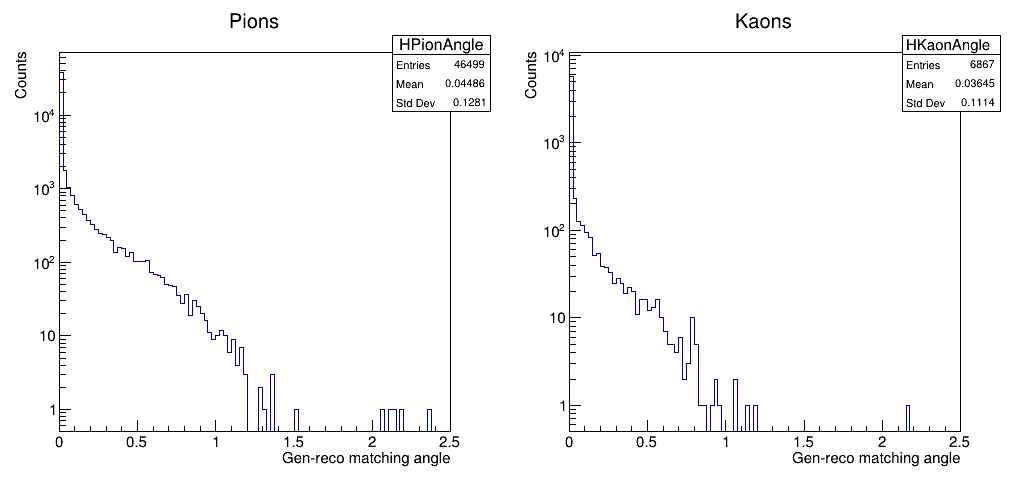

In [17]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 512)

Canvas.Divide(2)

Canvas.cd(1).SetLogy()
HPionAngle.Draw()

Canvas.cd(2).SetLogy()
HKaonAngle.Draw()

Canvas.Draw()
Canvas.SaveAs("GenRecoMatchingAngle.pdf")

In [18]:
# Now we make efficiency plots

In [19]:
def MakeEfficiencyPlots(IDs, Tag):
    HPTPass    = ROOT.TH1D("HPTPass", "No theta selection;Gen PT;Counts", 100, 0, 15)
    HPTAll     = ROOT.TH1D("HPTAll", "No theta selection;Gen PT;Counts", 100, 0, 15)
    HThetaPass = ROOT.TH1D("HThetaPass", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
    HThetaAll  = ROOT.TH1D("HThetaAll", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
    HPTInPass  = ROOT.TH1D("HPTInPass", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
    HPTInAll   = ROOT.TH1D("HPTInAll", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
    HPTBBPass  = ROOT.TH1D("HPTBBPass", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)
    HPTBBAll   = ROOT.TH1D("HPTBBAll", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)

    for iE in range(len(Gen)):
        # Again get stuff out of the awkwardness to speed things up
        GenPx = np.array(Gen[iE].px)
        GenPy = np.array(Gen[iE].py)
        GenPz = np.array(Gen[iE].pz)
        GenID = np.array(Gen[iE].id)
        RecoPx = np.array(Reco[iE].px)
        RecoPy = np.array(Reco[iE].py)
        RecoPz = np.array(Reco[iE].pz)

        NGen = len(GenPx)

        for iG in range(NGen):
            if GenID[iG] not in IDs:
                continue
            
            GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
            GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)
        
            HPTAll.Fill(GenPT)
            if GenPT > 0.4:
                HThetaAll.Fill(GenTheta)
            if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
                HPTInAll.Fill(GenPT)
            if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
                HPTBBAll.Fill(GenPT)
        
            if GenAngle[iE][iG] < 0.01:
                HPTPass.Fill(GenPT)
                if GenPT > 0.4:
                    HThetaPass.Fill(GenTheta)
                if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
                    HPTInPass.Fill(GenPT)
                if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
                    HPTBBPass.Fill(GenPT)

    GPTEfficiency = ROOT.TGraphAsymmErrors()
    GPTEfficiency.Divide(HPTPass, HPTAll)
    GPTEfficiency.SetTitle("No theta selection")
    GPTEfficiency.GetXaxis().SetTitle("Gen PT")
    GPTEfficiency.GetYaxis().SetTitle("Efficiency")

    GThetaEfficiency = ROOT.TGraphAsymmErrors()
    GThetaEfficiency.Divide(HThetaPass, HThetaAll)
    GThetaEfficiency.SetTitle("PT > 0.4")
    GThetaEfficiency.GetXaxis().SetTitle("Gen Theta")
    GThetaEfficiency.GetYaxis().SetTitle("Efficiency")

    GPTInEfficiency = ROOT.TGraphAsymmErrors()
    GPTInEfficiency.Divide(HPTInPass, HPTInAll)
    GPTInEfficiency.SetTitle("Theta = 20 - 160 degrees")
    GPTInEfficiency.GetXaxis().SetTitle("Gen PT")
    GPTInEfficiency.GetYaxis().SetTitle("Efficiency")

    GPTBBEfficiency = ROOT.TGraphAsymmErrors()
    GPTBBEfficiency.Divide(HPTBBPass, HPTBBAll)
    GPTBBEfficiency.SetTitle("Theta = 45 - 135 degrees")
    GPTBBEfficiency.GetXaxis().SetTitle("Gen PT")
    GPTBBEfficiency.GetYaxis().SetTitle("Efficiency")

    Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 2048)

    Canvas.Divide(2, 4)

    Canvas.cd(1).SetLogy()
    HPTAll.SetLineColor(ROOT.kRed)
    HPTAll.SetStats(0)
    HPTAll.Draw()
    HPTPass.SetLineColor(ROOT.kBlue)
    HPTPass.Draw("same")
    
    Canvas.cd(2).SetGridx()
    Canvas.cd(2).SetGridy()
    GPTEfficiency.Draw("ap")

    Canvas.cd(3)
    HThetaAll.SetLineColor(ROOT.kRed)
    HThetaAll.SetStats(0)
    HThetaAll.Draw()
    HThetaPass.SetLineColor(ROOT.kBlue)
    HThetaPass.Draw("same")

    Canvas.cd(4)
    GThetaEfficiency.Draw("ap")

    Canvas.cd(5).SetLogy()
    HPTInAll.SetLineColor(ROOT.kRed)
    HPTInAll.SetStats(0)
    HPTInAll.Draw()
    HPTInPass.SetLineColor(ROOT.kBlue)
    HPTInPass.Draw("same")

    Canvas.cd(6).SetGridx()
    Canvas.cd(6).SetGridy()
    GPTInEfficiency.Draw("ap")

    Canvas.cd(7).SetLogy()
    HPTBBAll.SetLineColor(ROOT.kRed)
    HPTBBAll.SetStats(0)
    HPTBBAll.Draw()
    HPTBBPass.SetLineColor(ROOT.kBlue)
    HPTBBPass.Draw("same")

    Canvas.cd(8).SetGridy()
    Canvas.cd(8).SetGridx()
    GPTBBEfficiency.Draw("ap")

    Canvas.Draw()
    Canvas.SaveAs(f"Efficiency_{Tag}.pdf")

In [20]:
MakeEfficiencyPlots([211, -211], 'Pion')
MakeEfficiencyPlots([321, -321], 'Kaon')

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas
Info in <TCanvas::Print>: pdf file Efficiency_Pion.pdf has been created
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Info in <TCanvas::Print>: pdf file Efficiency_Kaon.pdf has been created


In [21]:
# Now that we have something that kind of works, it's time to look into PID stuff.  Let's play with dedx first

In [22]:
HDEDXAll = ROOT.TH2D("HDEDXAll", "Everything;p;dE/dx", 100, 0, 2.5, 100, 0, 5)
HDEDXPion = ROOT.TH2D("HDEDXPion", "Matched with pions;p;dE/dx", 100, 0, 2.5, 100, 0, 5)
HDEDXKaon = ROOT.TH2D("HDEDXKaon", "Matched with kaons;p;dE/dx", 100, 0, 2.5, 100, 0, 5)
HDEDXProton = ROOT.TH2D("HDEDXProton", "Matched with protons;p;dE/dx", 100, 0, 2.5, 100, 0, 5)

for iE in range(len(Gen)):
    # Again get stuff out of the awkwardness to speed things up
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)
    DEDX = np.array(PID[iE].dedx)

    NReco = len(RecoPx)

    for iR in range(NReco):
        RecoPT = Magnitude(RecoPx[iR], RecoPy[iR], 0)
        RecoP = Magnitude(RecoPx[iR], RecoPy[iR], RecoPz[iR])
        RecoTheta = GetAngle(RecoPx[iR], RecoPy[iR], RecoPz[iR], 0, 0, 1)

        HDEDXAll.Fill(RecoP, DEDX[iR])

    NGen = len(Gen[iE].px)
    GenPx = np.array(Gen[iE].px)
    GenPy = np.array(Gen[iE].py)
    GenPz = np.array(Gen[iE].pz)
    GenID = np.array(Gen[iE].id)
    
    for iG in range(NGen):
        GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
        GenP = Magnitude(GenPx[iG], GenPy[iG], GenPz[iG])
        GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)

        MatchedDEDX = 0
        if GenMatch[iE][iG] > 0:
            Index = int(GenMatch[iE][iG])

            MatchedDEDX = DEDX[Index]
            RecoPT = Magnitude(RecoPx[Index], RecoPy[Index], 0)
            RecoP = Magnitude(RecoPx[Index], RecoPy[Index], RecoPz[Index])
            RecoTheta = GetAngle(RecoPx[Index], RecoPy[Index], RecoPz[Index], 0, 0, 1)

            if GenAngle[iE][iG] < 0.01:
                if GenID[iG] in [211,  -211]:
                    HDEDXPion.Fill(RecoP, MatchedDEDX)
                if GenID[iG] in [321,  -321]:
                    HDEDXKaon.Fill(RecoP, MatchedDEDX)
                if GenID[iG] in [2212,  -2212]:
                    HDEDXProton.Fill(RecoP, MatchedDEDX)

Info in <TCanvas::Print>: pdf file DEDXMatched.pdf has been created


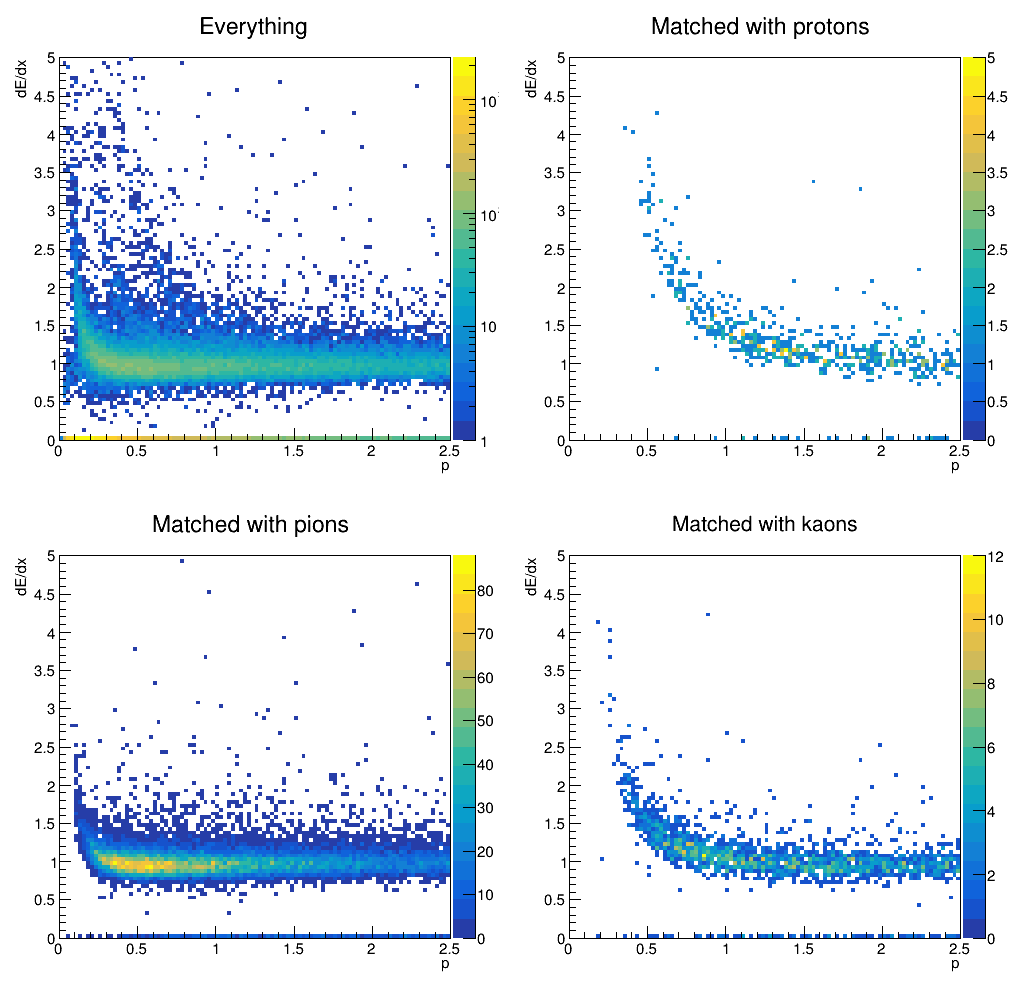

In [23]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 1024)

Canvas.Divide(2, 2)

Canvas.cd(1).SetLogz()
HDEDXAll.SetStats(0)
HDEDXAll.Draw("colz")

Canvas.cd(2)
HDEDXProton.SetStats(0)
HDEDXProton.Draw("colz")

Canvas.cd(3)
HDEDXPion.SetStats(0)
HDEDXPion.Draw("colz")

Canvas.cd(4)
HDEDXKaon.SetStats(0)
HDEDXKaon.Draw("colz")

Canvas.Draw()
Canvas.SaveAs("DEDXMatched.pdf")

In [24]:
# Are there some PID discriminant there?
# Yes, these are the branches
# 'Haidc_electronTag',
# 'Haidc_heavyTag',
# 'Haidc_kaonTag',
# 'Haidc_pionTag',
# 'Haidc_protonTag',
# 'Haidc_selectionFlag
# Let's make the matrix

In [25]:
def TagCountingPlots(Threshold, Tag):
    HTagMatrixStandard = ROOT.TH2D("HTagMatrixStandard", ";Tag;Gen ID", 7, 0, 7, 6, 0, 6)

    HTagMatrixStandard.GetXaxis().SetBinLabel(1, "pre-match")
    HTagMatrixStandard.GetXaxis().SetBinLabel(2, "matched")
    HTagMatrixStandard.GetXaxis().SetBinLabel(3, "e")
    HTagMatrixStandard.GetXaxis().SetBinLabel(4, "HF")
    HTagMatrixStandard.GetXaxis().SetBinLabel(5, "K")
    HTagMatrixStandard.GetXaxis().SetBinLabel(6, "pi")
    HTagMatrixStandard.GetXaxis().SetBinLabel(7, "p")

    HTagMatrixStandard.GetYaxis().SetBinLabel(1, "other")
    HTagMatrixStandard.GetYaxis().SetBinLabel(2, "pi")
    HTagMatrixStandard.GetYaxis().SetBinLabel(3, "K")
    HTagMatrixStandard.GetYaxis().SetBinLabel(4, "p")
    HTagMatrixStandard.GetYaxis().SetBinLabel(5, "e")
    HTagMatrixStandard.GetYaxis().SetBinLabel(6, "photon")

    Counts = np.zeros(3)

    for iE in range(len(Gen)):
        # Again get stuff out of the awkwardness to speed things up
        RecoPx = np.array(Reco[iE].px)
        RecoPy = np.array(Reco[iE].py)
        RecoPz = np.array(Reco[iE].pz)
        DEDX = np.array(PID[iE].dedx)
        ElectronTag = np.array(PID[iE].ElectronTag)
        HeavyTag = np.array(PID[iE].HeavyTag)
        KaonTag = np.array(PID[iE].KaonTag)
        PionTag = np.array(PID[iE].PionTag)
        ProtonTag = np.array(PID[iE].ProtonTag)

        NGen = len(Gen[iE].px)
        GenPx = np.array(Gen[iE].px)
        GenPy = np.array(Gen[iE].py)
        GenPz = np.array(Gen[iE].pz)
        GenID = np.array(Gen[iE].id)
        
        for iG in range(NGen):
            GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
            GenP = Magnitude(GenPx[iG], GenPy[iG], GenPz[iG])
            GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)
    
            MatchedDEDX = 0
            if GenMatch[iE][iG] > 0:
                Index = int(GenMatch[iE][iG])

                MatchedDEDX = DEDX[Index]
                RecoPT = Magnitude(RecoPx[Index], RecoPy[Index], 0)
                RecoP = Magnitude(RecoPx[Index], RecoPy[Index], RecoPz[Index])
                RecoTheta = GetAngle(RecoPx[Index], RecoPy[Index], RecoPz[Index], 0, 0, 1)

                TypeIndex = 0
                if GenID[iG] in [211,  -211]:
                    TypeIndex = 1
                if GenID[iG] in [321,  -321]:
                    TypeIndex = 2
                if GenID[iG] in [2212,  -2212]:
                    TypeIndex = 3
                if GenID[iG] in [11,  -11]:
                    TypeIndex = 4
                if GenID[iG] in [22]:
                    TypeIndex = 5

                HTagMatrixStandard.Fill(0, TypeIndex)
                if GenAngle[iE][iG] < 0.01:
                    HTagMatrixStandard.Fill(1, TypeIndex)
                    if ElectronTag[Index] >= Threshold:
                        HTagMatrixStandard.Fill(2, TypeIndex)
                    if HeavyTag[Index] >= Threshold:
                        HTagMatrixStandard.Fill(3, TypeIndex)
                    if KaonTag[Index] >= Threshold:
                        HTagMatrixStandard.Fill(4, TypeIndex)
                    if PionTag[Index] >= Threshold:
                        HTagMatrixStandard.Fill(5, TypeIndex)
                    if ProtonTag[Index] >= Threshold:
                        HTagMatrixStandard.Fill(6, TypeIndex)

    Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 768)

    HTagMatrixStandard.SetStats(0)
    HTagMatrixStandard.SetMarkerSize(2)
    HTagMatrixStandard.Draw("colz text00")

    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}Tagger.pdf")

    HTagMatrixStandard.Draw("text00")

    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}TaggerTextOnly.pdf")

In [26]:
TagCountingPlots(1, 'Loose')
TagCountingPlots(2, 'Standard')
TagCountingPlots(3, 'Tight')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas
Info in <TCanvas::Print>: pdf file LooseTagger.pdf has been created
Info in <TCanvas::Print>: pdf file LooseTaggerTextOnly.pdf has been created
Info in <TCanvas::Print>: pdf file StandardTagger.pdf has been created
Info in <TCanvas::Print>: pdf file StandardTaggerTextOnly.pdf has been created
Info in <TCanvas::Print>: pdf file TightTagger.pdf has been created
Info in <TCanvas::Print>: pdf file TightTaggerTextOnly.pdf has been created


In [56]:
def TagEfficiencyPlots(Threshold, IDs, Tag):

    HPTMatched = ROOT.TH1D("HPTMatched", "Theta = 20-160 degrees;Gen PT;Count", 50, 0, 10)
    HPTPionTag = ROOT.TH1D("HPTPionTag", "Theta = 20-160 degrees, tagged as pion;Gen PT;Count", 50, 0, 10)
    HPTElectronTag = ROOT.TH1D("HPTElectronTag", "Theta = 20-160 degrees, tagged as electron;Gen PT;Count", 50, 0, 10)
    HPTKaonTag = ROOT.TH1D("HPTKaonTag", "Theta = 20-160 degrees, tagged as kaon;Gen PT;Count", 50, 0, 10)
    HPTProtonTag = ROOT.TH1D("HPTProtonTag", "Theta = 20-160 degrees, tagged as proton;Gen PT;Count", 50, 0, 10)
    HPTHeavyTag = ROOT.TH1D("HPTHeavyTag", "Theta = 20-160 degrees, tagged as heavy flavor;Gen PT;Count", 50, 0, 10)
    HPTQKaonTag = ROOT.TH1D("HPTQKaonTag", "Theta = 20-160 degrees, tagged as Kaon(Q);Gen PT;Count", 50, 0, 10)
    HPTQProtonTag = ROOT.TH1D("HPTQKaonTag", "Theta = 20-160 degrees, tagged as Proton(Q);Gen PT;Count", 50, 0, 10)
    HPTVKaonTag = ROOT.TH1D("HPTQKaonTag", "Theta = 20-160 degrees, vetoed as Kaon(Q);Gen PT;Count", 50, 0, 10)
    HPTVProtonTag = ROOT.TH1D("HPTQKaonTag", "Theta = 20-160 degrees, vetoed as Proton(Q);Gen PT;Count", 50, 0, 10)

    HThetaMatched = ROOT.TH1D("HThetaMatched", "PT > 0.4;Gen PT;Count", 50, 0, np.pi)
    HThetaPionTag = ROOT.TH1D("HThetaPionTag", "PT > 0.4, tagged as pion;Gen PT;Count", 50, 0, np.pi)
    HThetaElectronTag = ROOT.TH1D("HThetaElectronTag", "PT > 0.4, tagged as electron;Gen PT;Count", 50, 0, np.pi)
    HThetaKaonTag = ROOT.TH1D("HThetaKaonTag", "PT > 0.4, tagged as kaon;Gen PT;Count", 50, 0, np.pi)
    HThetaProtonTag = ROOT.TH1D("HThetaProtonTag", "PT > 0.4, tagged as proton;Gen PT;Count", 50, 0, np.pi)
    HThetaHeavyTag = ROOT.TH1D("HThetaHeavyTag", "PT > 0.4, tagged as heavy flavor;Gen PT;Count", 50, 0, np.pi)
    HThetaQKaonTag = ROOT.TH1D("HThetaKaonTag", "PT > 0.4, tagged as kaon(Q);Gen PT;Count", 50, 0, np.pi)
    HThetaQProtonTag = ROOT.TH1D("HThetaProtonTag", "PT > 0.4, tagged as proton(Q);Gen PT;Count", 50, 0, np.pi)
    HThetaVKaonTag = ROOT.TH1D("HThetaKaonTag", "PT > 0.4, vetoed as kaon(Q);Gen PT;Count", 50, 0, np.pi)
    HThetaVProtonTag = ROOT.TH1D("HThetaProtonTag", "PT > 0.4, vetoed as proton(Q);Gen PT;Count", 50, 0, np.pi)

    for iE in range(len(Gen)):
        # Again get stuff out of the awkwardness to speed things up
        RecoPx = np.array(Reco[iE].px)
        RecoPy = np.array(Reco[iE].py)
        RecoPz = np.array(Reco[iE].pz)
        DEDX = np.array(PID[iE].dedx)
        ElectronTag = np.array(PID[iE].ElectronTag)
        HeavyTag = np.array(PID[iE].HeavyTag)
        KaonTag = np.array(PID[iE].KaonTag)
        PionTag = np.array(PID[iE].PionTag)
        ProtonTag = np.array(PID[iE].ProtonTag)
        QKaonTag = np.array(PID[iE].QKaonTag)
        QProtonTag = np.array(PID[iE].QProtonTag)

        NGen = len(Gen[iE].px)
        GenPx = np.array(Gen[iE].px)
        GenPy = np.array(Gen[iE].py)
        GenPz = np.array(Gen[iE].pz)
        GenID = np.array(Gen[iE].id)
        
        for iG in range(NGen):
            GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
            GenP = Magnitude(GenPx[iG], GenPy[iG], GenPz[iG])
            GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)
    
            MatchedDEDX = 0
            if GenMatch[iE][iG] > 0 and GenAngle[iE][iG] < 0.01:
                Index = int(GenMatch[iE][iG])

                MatchedDEDX = DEDX[Index]
                RecoPT = Magnitude(RecoPx[Index], RecoPy[Index], 0)
                RecoP = Magnitude(RecoPx[Index], RecoPy[Index], RecoPz[Index])
                RecoTheta = GetAngle(RecoPx[Index], RecoPy[Index], RecoPz[Index], 0, 0, 1)

                if GenID[iG] in IDs:
                    if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
                        HPTMatched.Fill(GenPT)
                        if PionTag[Index] >= Threshold:
                            HPTPionTag.Fill(GenPT)
                        if KaonTag[Index] >= Threshold:
                            HPTKaonTag.Fill(GenPT)
                        if ProtonTag[Index] >= Threshold:
                            HPTProtonTag.Fill(GenPT)
                        if ElectronTag[Index] >= Threshold:
                            HPTElectronTag.Fill(GenPT)
                        if HeavyTag[Index] >= Threshold:
                            HPTHeavyTag.Fill(GenPT)
                        if QKaonTag[Index] >= Threshold:
                            HPTQKaonTag.Fill(GenPT)
                        if QProtonTag[Index] >= Threshold:
                            HPTQProtonTag.Fill(GenPT)
                        if QKaonTag[Index] == 0:
                            HPTVKaonTag.Fill(GenPT)
                        if QProtonTag[Index] == 0:
                            HPTVProtonTag.Fill(GenPT)

                    if GenPT > 0.4:
                        HThetaMatched.Fill(GenTheta)
                        if PionTag[Index] >= Threshold:
                            HThetaPionTag.Fill(GenTheta)
                        if KaonTag[Index] >= Threshold:
                            HThetaKaonTag.Fill(GenTheta)
                        if ProtonTag[Index] >= Threshold:
                            HThetaProtonTag.Fill(GenTheta)
                        if ElectronTag[Index] >= Threshold:
                            HThetaElectronTag.Fill(GenTheta)
                        if HeavyTag[Index] >= Threshold:
                            HThetaHeavyTag.Fill(GenTheta)
                        if QKaonTag[Index] >= Threshold:
                            HThetaQKaonTag.Fill(GenTheta)
                        if QProtonTag[Index] >= Threshold:
                            HThetaQProtonTag.Fill(GenTheta)
                        if QKaonTag[Index] == 0:
                            HThetaVKaonTag.Fill(GenTheta)
                        if QProtonTag[Index] == 0:
                            HThetaVProtonTag.Fill(GenTheta)

    GPTPionTag = ROOT.TGraphAsymmErrors()
    GPTKaonTag = ROOT.TGraphAsymmErrors()
    GPTProtonTag = ROOT.TGraphAsymmErrors()
    GPTElectronTag = ROOT.TGraphAsymmErrors()
    GPTHeavyTag = ROOT.TGraphAsymmErrors()
    GPTQKaonTag = ROOT.TGraphAsymmErrors()
    GPTQProtonTag = ROOT.TGraphAsymmErrors()
    GPTVKaonTag = ROOT.TGraphAsymmErrors()
    GPTVProtonTag = ROOT.TGraphAsymmErrors()

    GThetaPionTag = ROOT.TGraphAsymmErrors()
    GThetaKaonTag = ROOT.TGraphAsymmErrors()
    GThetaProtonTag = ROOT.TGraphAsymmErrors()
    GThetaElectronTag = ROOT.TGraphAsymmErrors()
    GThetaHeavyTag = ROOT.TGraphAsymmErrors()
    GThetaQKaonTag = ROOT.TGraphAsymmErrors()
    GThetaQProtonTag = ROOT.TGraphAsymmErrors()
    GThetaVKaonTag = ROOT.TGraphAsymmErrors()
    GThetaVProtonTag = ROOT.TGraphAsymmErrors()

    GPTPionTag.Divide(HPTPionTag, HPTMatched)
    GPTKaonTag.Divide(HPTKaonTag, HPTMatched)
    GPTProtonTag.Divide(HPTProtonTag, HPTMatched)
    GPTElectronTag.Divide(HPTElectronTag, HPTMatched)
    GPTHeavyTag.Divide(HPTHeavyTag, HPTMatched)
    GPTQKaonTag.Divide(HPTQKaonTag, HPTMatched)
    GPTQProtonTag.Divide(HPTQProtonTag, HPTMatched)
    GPTVKaonTag.Divide(HPTVKaonTag, HPTMatched)
    GPTVProtonTag.Divide(HPTVProtonTag, HPTMatched)

    GThetaPionTag.Divide(HThetaPionTag, HThetaMatched)
    GThetaKaonTag.Divide(HThetaKaonTag, HThetaMatched)
    GThetaProtonTag.Divide(HThetaProtonTag, HThetaMatched)
    GThetaElectronTag.Divide(HThetaElectronTag, HThetaMatched)
    GThetaHeavyTag.Divide(HThetaHeavyTag, HThetaMatched)
    GThetaQKaonTag.Divide(HThetaQKaonTag, HThetaMatched)
    GThetaQProtonTag.Divide(HThetaQProtonTag, HThetaMatched)
    GThetaVKaonTag.Divide(HThetaVKaonTag, HThetaMatched)
    GThetaVProtonTag.Divide(HThetaVProtonTag, HThetaMatched)

    GPTPionTag.SetTitle(f"Tagging efficiency for {Tag}, 20-160 degrees")
    GPTPionTag.GetXaxis().SetTitle("Gen PT")
    GPTPionTag.GetYaxis().SetTitle("Tagging efficiency")
    GPTPionTag.GetYaxis().SetRangeUser(0, 1.05)

    GThetaPionTag.SetTitle(f"Tagging efficiency for {Tag}, PT > 0.4")
    GThetaPionTag.GetXaxis().SetTitle("Gen theta")
    GThetaPionTag.GetYaxis().SetTitle("Tagging efficiency")
    GThetaPionTag.GetYaxis().SetRangeUser(0, 1.05)

    GPTQKaonTag.SetTitle(f"Tagging efficiency for {Tag}, 20-160 degrees")
    GPTQKaonTag.GetXaxis().SetTitle("Gen PT")
    GPTQKaonTag.GetYaxis().SetTitle("Tagging efficiency")
    GPTQKaonTag.GetYaxis().SetRangeUser(0, 1.05)

    GThetaQKaonTag.SetTitle(f"Tagging efficiency for {Tag}, PT > 0.4")
    GThetaQKaonTag.GetXaxis().SetTitle("Gen theta")
    GThetaQKaonTag.GetYaxis().SetTitle("Tagging efficiency")
    GThetaQKaonTag.GetYaxis().SetRangeUser(0, 1.05)

    Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 768)

    GPTPionTag.SetLineColor(ROOT.kRed)
    GPTKaonTag.SetLineColor(ROOT.kGreen)
    GPTProtonTag.SetLineColor(ROOT.kMagenta)
    GPTElectronTag.SetLineColor(ROOT.kCyan)
    GPTHeavyTag.SetLineColor(ROOT.kBlue)
    
    GPTPionTag.SetMarkerColor(ROOT.kRed)
    GPTKaonTag.SetMarkerColor(ROOT.kGreen)
    GPTProtonTag.SetMarkerColor(ROOT.kMagenta)
    GPTElectronTag.SetMarkerColor(ROOT.kCyan)
    GPTHeavyTag.SetMarkerColor(ROOT.kBlue)

    GPTPionTag.SetMarkerStyle(20)
    GPTKaonTag.SetMarkerStyle(20)
    GPTProtonTag.SetMarkerStyle(20)
    GPTElectronTag.SetMarkerStyle(20)
    GPTHeavyTag.SetMarkerStyle(20)
    
    GPTPionTag.Draw("apl")
    GPTProtonTag.Draw("pl")
    GPTKaonTag.Draw("pl")
    GPTElectronTag.Draw("pl")
    GPTHeavyTag.Draw("pl")

    Legend = ROOT.TLegend(0.70, 0.15, 0.95, 0.35)
    Legend.AddEntry(GPTPionTag, "Pion Tag", "pl")
    Legend.AddEntry(GPTElectronTag, "Electron Tag", "pl")
    Legend.AddEntry(GPTKaonTag, "Kaon Tag", "pl")
    Legend.AddEntry(GPTProtonTag, "Proton Tag", "pl")
    Legend.AddEntry(GPTHeavyTag, "Heavy flavor tag", "pl")
    Legend.Draw()

    Canvas.SetLogy(False)
    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}TagPTEfficiency.pdf")

    GPTPionTag.GetYaxis().SetRangeUser(1e-3, 1.1)
    
    Canvas.SetLogy(True)
    Canvas.SaveAs(f"{Tag}TagPTEfficiencyLog.pdf")

    GThetaPionTag.SetLineColor(ROOT.kRed)
    GThetaKaonTag.SetLineColor(ROOT.kGreen)
    GThetaProtonTag.SetLineColor(ROOT.kMagenta)
    GThetaElectronTag.SetLineColor(ROOT.kCyan)
    GThetaHeavyTag.SetLineColor(ROOT.kBlue)
    
    GThetaPionTag.SetMarkerColor(ROOT.kRed)
    GThetaKaonTag.SetMarkerColor(ROOT.kGreen)
    GThetaProtonTag.SetMarkerColor(ROOT.kMagenta)
    GThetaElectronTag.SetMarkerColor(ROOT.kCyan)
    GThetaHeavyTag.SetMarkerColor(ROOT.kBlue)

    GThetaPionTag.SetMarkerStyle(20)
    GThetaKaonTag.SetMarkerStyle(20)
    GThetaProtonTag.SetMarkerStyle(20)
    GThetaElectronTag.SetMarkerStyle(20)
    GThetaHeavyTag.SetMarkerStyle(20)
    
    GThetaPionTag.Draw("apl")
    GThetaProtonTag.Draw("pl")
    GThetaKaonTag.Draw("pl")
    GThetaElectronTag.Draw("pl")
    GThetaHeavyTag.Draw("pl")

    Legend = ROOT.TLegend(0.70, 0.15, 0.95, 0.35)
    Legend.AddEntry(GPTPionTag, "Pion Tag", "pl")
    Legend.AddEntry(GPTElectronTag, "Electron Tag", "pl")
    Legend.AddEntry(GPTKaonTag, "Kaon Tag", "pl")
    Legend.AddEntry(GPTProtonTag, "Proton Tag", "pl")
    Legend.AddEntry(GPTHeavyTag, "Heavy flavor tag", "pl")
    Legend.Draw()

    Canvas.SetLogy(False)
    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}TagThetaEfficiency.pdf")

    GThetaPionTag.GetYaxis().SetRangeUser(1e-3, 1.1)
    
    Canvas.SetLogy(True)
    Canvas.SaveAs(f"{Tag}TagThetaEfficiencyLog.pdf")

    GPTQKaonTag.SetLineColor(ROOT.kGreen)
    GPTQProtonTag.SetLineColor(ROOT.kMagenta)
    GPTVKaonTag.SetLineColor(ROOT.kRed)
    GPTVProtonTag.SetLineColor(ROOT.kCyan)
    
    GPTQKaonTag.SetMarkerColor(ROOT.kGreen)
    GPTQProtonTag.SetMarkerColor(ROOT.kMagenta)
    GPTVKaonTag.SetMarkerColor(ROOT.kRed)
    GPTVProtonTag.SetMarkerColor(ROOT.kCyan)

    GPTQKaonTag.SetMarkerStyle(20)
    GPTQProtonTag.SetMarkerStyle(20)
    GPTVKaonTag.SetMarkerStyle(20)
    GPTVProtonTag.SetMarkerStyle(20)
    
    GPTQKaonTag.Draw("apl")
    GPTQProtonTag.Draw("pl")
    GPTVKaonTag.Draw("pl")
    GPTVProtonTag.Draw("pl")

    Legend = ROOT.TLegend(0.70, 0.15, 0.95, 0.35)
    Legend.AddEntry(GPTQKaonTag, "Kaon Tag", "pl")
    Legend.AddEntry(GPTQProtonTag, "Proton Tag", "pl")
    Legend.AddEntry(GPTVKaonTag, "Kaon Veto", "pl")
    Legend.AddEntry(GPTVProtonTag, "Proton Veto", "pl")
    Legend.Draw()

    Canvas.SetLogy(False)
    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}QTagPTEfficiency.pdf")

    GPTQKaonTag.GetYaxis().SetRangeUser(1e-3, 1.1)
    
    Canvas.SetLogy(True)
    Canvas.SaveAs(f"{Tag}QTagPTEfficiencyLog.pdf")

    GThetaQKaonTag.SetLineColor(ROOT.kGreen)
    GThetaQProtonTag.SetLineColor(ROOT.kMagenta)
    GThetaVKaonTag.SetLineColor(ROOT.kRed)
    GThetaVProtonTag.SetLineColor(ROOT.kCyan)
    
    GThetaQKaonTag.SetMarkerColor(ROOT.kGreen)
    GThetaQProtonTag.SetMarkerColor(ROOT.kMagenta)
    GThetaVKaonTag.SetMarkerColor(ROOT.kRed)
    GThetaVProtonTag.SetMarkerColor(ROOT.kCyan)

    GThetaQKaonTag.SetMarkerStyle(20)
    GThetaQProtonTag.SetMarkerStyle(20)
    GThetaVKaonTag.SetMarkerStyle(20)
    GThetaVProtonTag.SetMarkerStyle(20)
    
    GThetaQKaonTag.Draw("apl")
    GThetaQProtonTag.Draw("pl")
    GThetaVKaonTag.Draw("pl")
    GThetaVProtonTag.Draw("pl")

    Legend = ROOT.TLegend(0.70, 0.15, 0.95, 0.35)
    Legend.AddEntry(GThetaQKaonTag, "Kaon Tag", "pl")
    Legend.AddEntry(GThetaQProtonTag, "Proton Tag", "pl")
    Legend.AddEntry(GThetaVKaonTag, "Kaon Veto", "pl")
    Legend.AddEntry(GThetaVProtonTag, "Proton Veto", "pl")
    Legend.Draw()

    Canvas.SetLogy(False)
    Canvas.Draw()
    Canvas.SaveAs(f"{Tag}QTagThetaEfficiency.pdf")

    GThetaQKaonTag.GetYaxis().SetRangeUser(1e-3, 1.1)
    
    Canvas.SetLogy(True)
    Canvas.SaveAs(f"{Tag}QTagThetaEfficiencyLog.pdf")


In [57]:
TagEfficiencyPlots(1, [211, -211], 'PionLoose')
TagEfficiencyPlots(2, [211, -211], 'PionStandard')
TagEfficiencyPlots(3, [211, -211], 'PionTight')

TagEfficiencyPlots(1, [321, -321], 'KaonLoose')
TagEfficiencyPlots(2, [321, -321], 'KaonStandard')
TagEfficiencyPlots(3, [321, -321], 'KaonTight')

TagEfficiencyPlots(1, [2212, -2212], 'ProtonLoose')
TagEfficiencyPlots(2, [2212, -2212], 'ProtonStandard')
TagEfficiencyPlots(3, [2212, -2212], 'ProtonTight')

TagEfficiencyPlots(1, [11, -11], 'ElectronLoose')
TagEfficiencyPlots(2, [11, -11], 'ElectronStandard')
TagEfficiencyPlots(3, [11, -11], 'ElectronTight')

Warning in <TROOT::Append>: Replacing existing TH1: HPTMatched (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTPionTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTElectronTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTKaonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTProtonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTHeavyTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTQKaonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTQKaonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTQKaonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPTQKaonTag (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HThetaMatched (Potential memory leak).
Warning in <TROOT:

In [ ]:
# Let's look at the Q taggers

In [47]:
Bins = np.array([-1, 0, 0.5, 1, 2, 3, 4, 5])

HQTaggerAll = ROOT.TH2D("HQTaggerAll", "All reco particles;Proton tag;Kaon tag", 7, Bins, 7, Bins)
HQTaggerPion = ROOT.TH2D("HQTaggerPion", "Pions;Proton tag;Kaon tag", 7, Bins, 7, Bins)
HQTaggerKaon = ROOT.TH2D("HQTaggerKaon", "Kaons;Proton tag;Kaon tag", 7, Bins, 7, Bins)
HQTaggerProton = ROOT.TH2D("HQTaggerProton", "Protons;Proton tag;Kaon tag", 7, Bins, 7, Bins)

for iE in range(len(Gen)):

    QProtonTag = np.array(PID[iE].QProtonTag)
    QKaonTag = np.array(PID[iE].QKaonTag)
    
    GenPx = np.array(Gen[iE].px)
    GenPy = np.array(Gen[iE].py)
    GenPz = np.array(Gen[iE].pz)
    GenID = np.array(Gen[iE].id)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    NGen = len(GenPx)
    NReco = len(RecoPx)
    
    for iR in range(NReco):
        HQTaggerAll.Fill(QProtonTag[iR], QKaonTag[iR])

    for iG in range(NGen):
        if GenAngle[iE][iG] < 0.01:
            Index = int(GenMatch[iE][iG])
            if GenID[iG] in [211,  -211]:
                HQTaggerPion.Fill(QProtonTag[Index], QKaonTag[Index])
            if GenID[iG] in [321,  -321]:
                HQTaggerKaon.Fill(QProtonTag[Index], QKaonTag[Index])
            if GenID[iG] in [2212,  -2212]:
                HQTaggerProton.Fill(QProtonTag[Index], QKaonTag[Index])


Warning in <TROOT::Append>: Replacing existing TH1: HQTaggerAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HQTaggerPion (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HQTaggerKaon (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HQTaggerProton (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


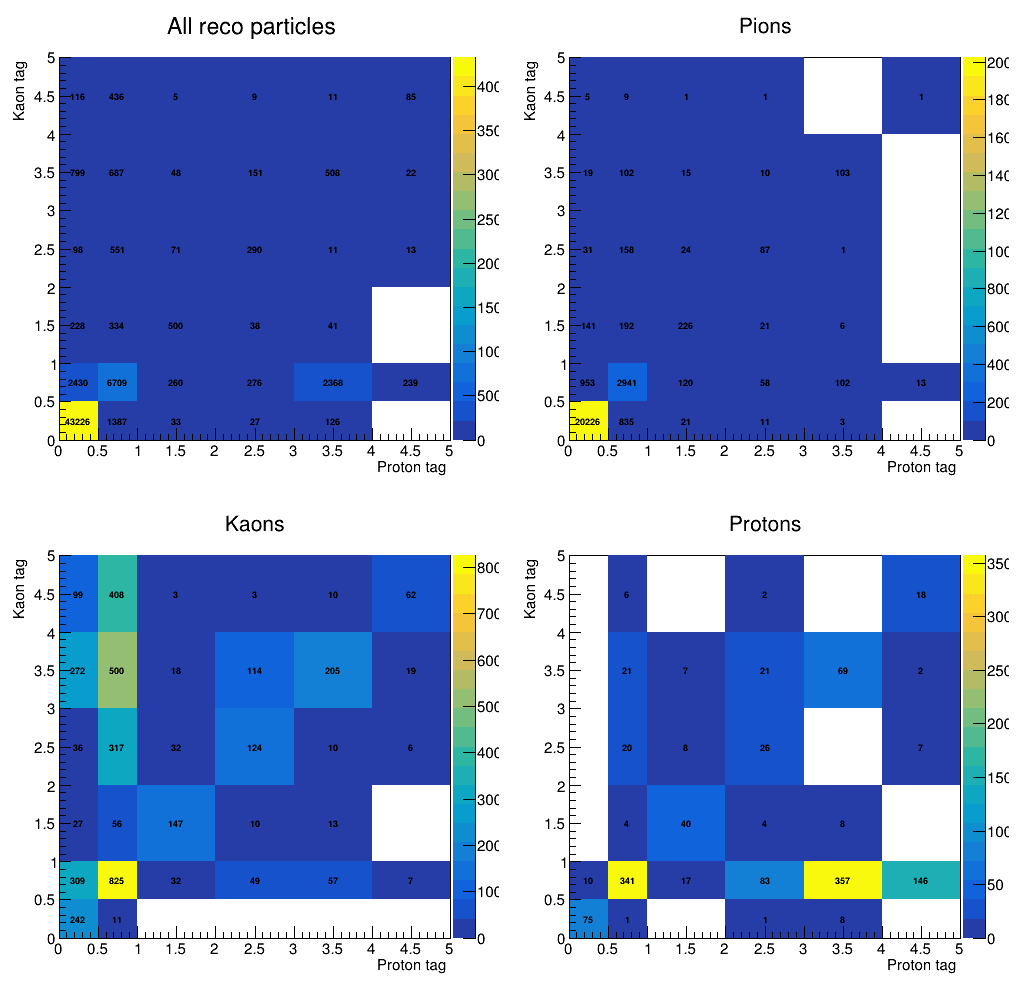

In [49]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 1024)

HQTaggerAll.GetXaxis().SetRangeUser(0, 5)
HQTaggerAll.GetYaxis().SetRangeUser(0, 5)
HQTaggerPion.GetXaxis().SetRangeUser(0, 5)
HQTaggerPion.GetYaxis().SetRangeUser(0, 5)
HQTaggerKaon.GetXaxis().SetRangeUser(0, 5)
HQTaggerKaon.GetYaxis().SetRangeUser(0, 5)
HQTaggerProton.GetXaxis().SetRangeUser(0, 5)
HQTaggerProton.GetYaxis().SetRangeUser(0, 5)

Canvas.Divide(2, 2)

Canvas.cd(1)
HQTaggerAll.SetStats(0)
HQTaggerAll.Draw("colz text00")

Canvas.cd(2)
HQTaggerPion.SetStats(0)
HQTaggerPion.Draw("colz text00")

Canvas.cd(3)
HQTaggerKaon.SetStats(0)
HQTaggerKaon.Draw("colz text00")

Canvas.cd(4)
HQTaggerProton.SetStats(0)
HQTaggerProton.Draw("colz text00")

Canvas.Draw()